# Notebook for troubleshooting and showcasing protocols.

## Helper functions

In [ ]:
def oneD_plot_amplitude(dataset):
    plt.plot(abs(dataset.avg_q +1j*dataset.avg_i) )
    plt.ylabel('Amplitude')
    for coordinate in dataset.coords:
        plt.xlabel(dataset.coords[coordinate].long_name + f' ({dataset.coords[coordinate].unit})')
    pass



## Initializing the station and the experiment

In [1]:
import qcodes as qc
from qcodes.instrument import Instrument, ManualParameter
from qcodes.station import Station

from metainstruments.ZCUStation import ZCU216Station
from metainstruments.ZCUMetainstrument import ZCU216Metainstrument
from measurements.Protocols import Protocol
from measurements.T1Protocol import T1Protocol
from measurements.PulseProbeSpectroscopyProtocol import PulseProbeSpectroscopyProtocol
from measurements.NDSweepProtocol import NDSweepProtocol
from qick import *


import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Initializing the station and the database
qc.initialise_or_create_database_at("./experiment-data/zcu_test_data.db")
station = ZCU216Station()

In [3]:
#Initializing the experiment
experiment = qc.load_or_create_experiment(
                experiment_name="ZCU_QICK_QCODES_TEST",
                sample_name="None")

## Adding QICK Channels

In [7]:
# The following command can be used to configure to see what qick channel corresponds to what physical port
print(station.troubleshoot())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.211
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

In [9]:
#At the time of writing, we have connected DACs 2_231 and 0_231 to the adc's and oscilloscopes, these have  
#qick channels 6 and 4. The physically connected ADC channel is 0_226. Thus, our configuration will be:
station.add_DAC_channel(name="Probe", channel=6)
station.add_DAC_channel(name="Readout", channel=4)
station.add_ADC_channel(name="ADC", channel=0)

## VNA program

The vna program, handled by the NDSweepProtocol, sends a pulse from the 'probe' dac channel and triggers the 'adc' adc channel. The attributes of the sent pulse are contained in the parameters of the 'probe' dac channel, and the readout settings are contained in the protocol parameters.

In [ ]:
# Initialization of the protocol
vnaprotocol = station.add_protocol(NDSweepProtocol(name='vna'))

In [11]:
station.vna.print_readable_snapshot()

vna:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': None, 'model': 'vna', 'serial': None, 'firmware'...
adc_trig_offset :	100 (Clock ticks)
readout_length  :	5 (us)
relax_delay     :	0.1 (us)
reps            :	400 


In [19]:
station.Probe.print_readable_snapshot()

Probe:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': None, 'model': 'Probe', 'serial': None, 'firmware':...
channel      :	6 
nqz          :	1 
pulse_freq   :	500 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)


If you are confused by some parameter, try reading the label

In [22]:
print(station.vna.relax_delay.label)
print(station.vna.adc_trig_offset.label)

Delay between reps
Delay between measuring pulse and ADC initialization


Once you are satisfied with the default parameter values for your experiment, you can run a vna program that
sweeps the parameters and values defined in params_and_values, with the previously configurated parameter values as follows: 

In [57]:
# Iterate the frequency of the probe pulse from 100 to 5000 MHz, with 10 iteration points. The probe
# channel is defined in the dac_channels as 'probe', and the adc channel is defined in adc_channels. The
# protocol you defined and configured is set as the protocol.

vna_run_id = station.measure_iq(params_and_values = {  station.Probe.pulse_freq: [100, 5000, 10]}, 
                         protocol = vnaprotocol, 
                         dac_channels = {'probe': station.Probe},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 1460. 


The program has run succesfully, and the measure_iq method returns a run_id, with wich you can access the database:

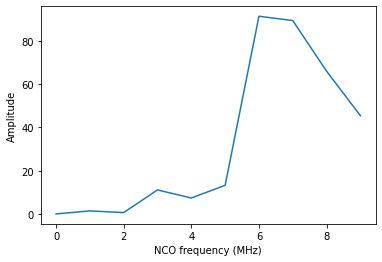

In [56]:
dataset = qc.load_by_id(vna_run_id).to_xarray_dataset()
dataset
oneD_plot_amplitude(dataset)

## Testing VNA

In [89]:
station.Readout.pulse_gain(10000)
station.Readout.pulse_length(0.1)
station.vna.reps(1)

station.print_configuration()

pvals = {  station.Readout.pulse_freq: [1000, 1000, 1]}

In [95]:
vna_run_id = station.measure_iq(params_and_values = pvals, 
                         protocol = vnaprotocol, 
                         dac_channels = {'probe': station.Readout},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 1484. 


## Testing pulse probe spectroscopy

In [96]:
station.add_protocol(PulseProbeSpectroscopyProtocol(name='pps'))

<PulseProbeSpectroscopyProtocol: pps>

In [97]:
station.Probe.pulse_gain(10000)
station.Readout.pulse_length(0.1)
station.pps.reps(1)

station.print_configuration()

pvals = {  station.Readout.pulse_freq: [1000, 1000, 1]}

Station configuration:


zcu:
	parameter value
--------------------------------------------------------------------------------
IDN :	{'vendor': None, 'model': 'zcu', 'serial': None, 'firmware': None} 

QubitChannel:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': None, 'model': 'QubitChannel', 'serial': None, 'fir...
channel      :	6 
nqz          :	1 
pulse_freq   :	500 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)

ReadoutChannel:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': None, 'model': 'ReadoutChannel', 'serial': None, 'f...
channel      :	4 
nqz          :	1 
pulse_freq   :	500 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)

ADC:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'ven

In [79]:
ppsp_id = station.measure_iq( params_and_values = {station.QubitChannel.pulse_freq: [ 4000, 4100, 5 ], station.QubitChannel.pulse_gain: [ 4000, 4100, 5 ]},
                            protocol = ppsproto,
                            dac_channels = {'qubit': station.Probe, 'readout' : station.Readout},
                            adc_channels = {'adc': station.ADC})

NameError: name 'ppsproto' is not defined